<a href="https://colab.research.google.com/github/rammahayufitra/Microservices/blob/main/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from torchvision import datasets
import torch
!mkdir data_task1 
data_folder = '/content/data_task1/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download=False, train=True)
tr_images = fmnist.data 
tr_targets = fmnist.targets

mkdir: cannot create directory ‘data_task1’: File exists


In [7]:
unique_values = tr_targets.unique()
print(f'tr_images & tr_targets:\n\tX -{tr_images.shape}\n\tY \
-{tr_targets.shape}\n\tY-Unique Values : {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{fmnist.classes}')

tr_images & tr_targets:
	X -torch.Size([60000, 28, 28])
	Y -torch.Size([60000])
	Y-Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


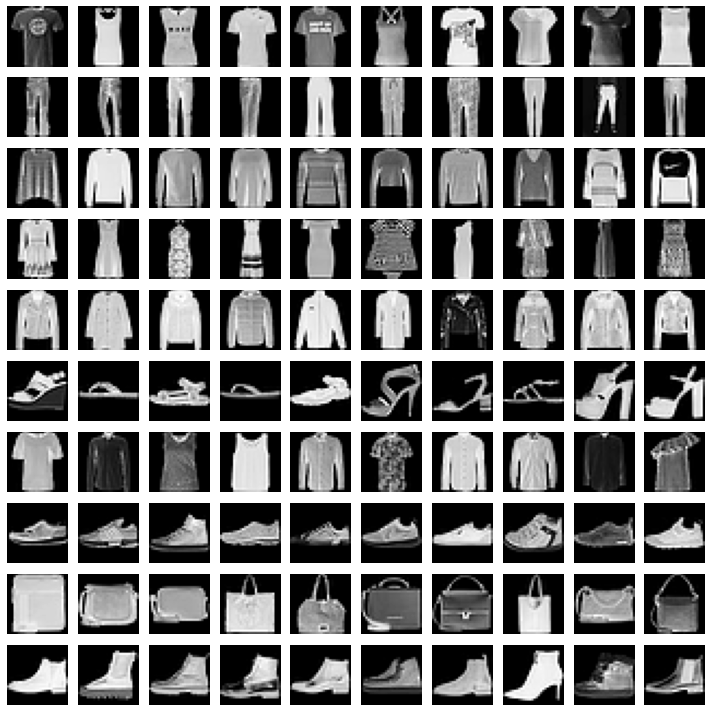

In [11]:
import matplotlib.pyplot as plt 
%matplotlib inline 
import numpy as np 
R,C = len(tr_targets.unique()), 10 
fig, ax = plt.subplots(R,C, figsize=(10,10))
for label_class, plot_row in enumerate(ax):
  label_x_rows = np.where(tr_targets == label_class)[0]
  for plot_cell in plot_row:
    plot_cell.grid(False); plot_cell.axis('off')
    ix = np.random.choice(label_x_rows)
    x, y = tr_images[ix], tr_targets[ix]
    plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

**Training** **Neural** **Network**

In [13]:
from torch.utils.data import Dataset, DataLoader 
import torch 
import torch.nn as nn 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 

device = "cuda" if torch.cuda.is_available() else "cpu"
print('device', device)
from torchvision import datasets 
data_folder = '/content/data_task1/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download=False, train=True)
tr_images = fmnist.data 
tr_targets = fmnist.targets




device cpu


In [14]:
class FMNISTDataset(Dataset):
  def __init__(self, x,y):
    x = x.float()
    x = x.view(-1,28*28)
    self.x, self.y = x, y 
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  def __len__(self):
    return len(self.x)
    

In [28]:
def get_data(): 
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  return trn_dl

In [37]:
from torch.optim import SGD 
def get_model(): 
  model = nn.Sequential(
      nn.Linear(28*28, 1000),
      nn.ReLU(), 
      nn.Linear(1000,10)).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr=1e-2)
  return model, loss_fn, optimizer 

  

In [38]:
def train_batch(x, y, model, opt, loss_fn):
    model.train() # <- let's hold on to this until we reach dropout section
    # call your model like any python function on your batch of inputs
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # based on the forward pass in `model(x)` compute all the gradients of     
    # 'model.parameters()'
    batch_loss.backward()
    # apply new-weights = f(old-weights, old-weight-gradients) where 
    # "f" is the optimizer
    optimizer.step()
    # Flush gradients memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()


In [39]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # <- let's wait till we get to dropout section
    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)
    # compute if the location of maximum in each row coincides 
    # with ground truth
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [41]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()


In [42]:
losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


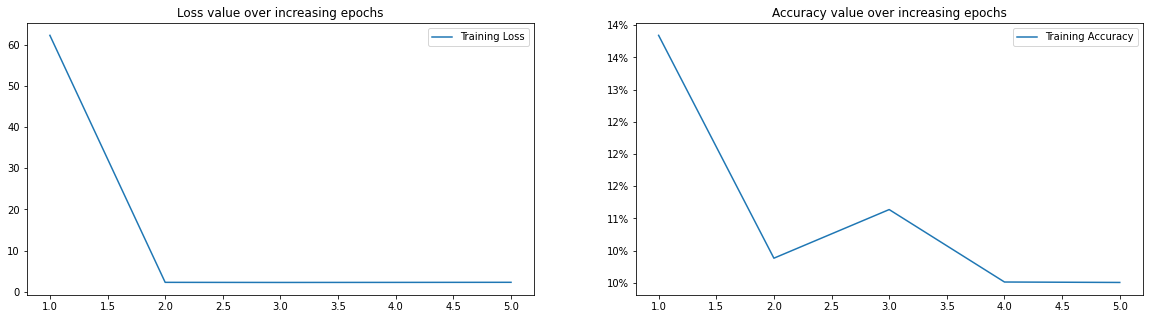

In [43]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()